In [1]:
import scCube
from scCube import scCube
from scCube.visualization import *
from scCube.utils import *
from pathlib import Path
from matplotlib.pyplot import rc_context
import pandas as pd
import scanpy as sc
import numpy as np
import warnings
import time
warnings.filterwarnings("ignore")

In [2]:
model = scCube()

In [3]:
import os
new_directory = "/slurm/home/yrd/liaolab/chenrenjie/R_dataset/"
os.chdir(new_directory)

In [4]:
train_sample = '151673'
sc_data = pd.read_csv(f"./DLPFC/{train_sample}/data.csv", index_col = 0)
sc_meta = pd.read_csv(f"./DLPFC/{train_sample}/meta.csv", index_col = 0)
adata = model.pre_process(
    sc_data=sc_data.T, 
    sc_meta=sc_meta,
    is_normalized=False
    )
coor_df = adata.obs[["imagecol","imagerow"]]
adata.obsm["spatial"] = coor_df.to_numpy()
adata.obs['spot'] = adata.obs.index
adata.layers["data"] = adata.X

the input is count matrix, normalizing it firstly...


In [5]:
raw = 'Layer1'
new = 'Layer2'
list1 = ['Layer1', 'Layer2', 'Layer3', 'Layer4', 'Layer5', 'Layer6', 'WM']
list2 = ['Layer2', 'Layer2', 'Layer3', 'Layer4', 'Layer5', 'Layer6', 'WM']

test_adata = adata.copy()
test_adata.obs['sim_truth'] = test_adata.obs['ground_truth']
for i in range(len(list1)):
    test_adata.obs.loc[test_adata.obs['ground_truth'] == list1[i], 'sim_truth'] = list2[i]

In [6]:
train_adata = adata.copy()
drop_cluter = list(set(list1) - set(list2))
for i in range(len(drop_cluter)):
    train_adata = train_adata[train_adata.obs["ground_truth"] != drop_cluter[i]]    

In [7]:
save_path = "/slurm/home/yrd/liaolab/chenrenjie/Benchmark/Simulations/"
os.chdir(save_path)

In [8]:
generate_sc_meta, generate_sc_data = model.train_vae_and_generate_cell(
    sc_adata=train_adata,
    celltype_key='ground_truth',
    cell_key='spot',
    target_num=dict(test_adata.obs.sim_truth.value_counts()),
    batch_size=512,
    epoch_num=10000,
    lr=0.0001,
    hidden_size=128,
    save_model=True,
    save_path=save_path,
    project_name='sim3',
    used_device='cuda:0')
generate_sc_data, generate_sc_meta = model.generate_pattern_reference(
        sc_adata=test_adata,
        generate_sc_data=generate_sc_data,
        generate_sc_meta=generate_sc_meta,
        celltype_key='sim_truth',
        spatial_key=['imagecol', 'imagerow'],
        cost_metric='sqeuclidean')

generating by the targeted proportion of cell types...
begin vae training...


Train Epoch: 9999: 100%|██████████| 10000/10000 [2:00:03<00:00,  1.39it/s, loss=0.2088, min_loss=0.2074] 


vae training done!
saving the trained vae model...
save trained vae in /slurm/home/yrd/liaolab/chenrenjie/Benchmark/Simulations/sim3.pth.


Generate Epoch: 2: 100%|██████████| 3611/3611 [00:00<00:00, 5670.64it/s]


generated done!
data have been prepared!


<AxesSubplot: title={'center': 'ground_truth'}, xlabel='spatial1', ylabel='spatial2'>

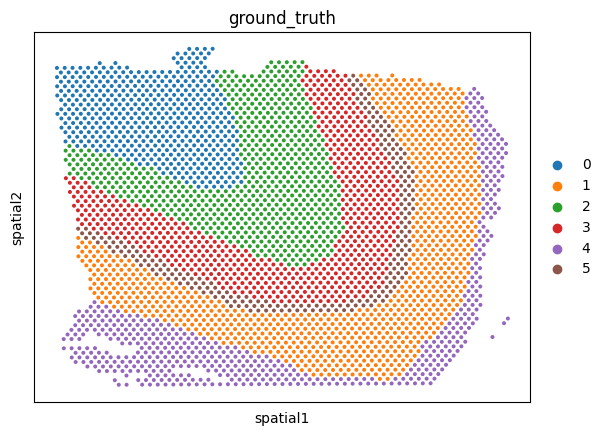

In [9]:
new_adata = sc.AnnData(generate_sc_data.T)
new_adata.var_names_make_unique()
new_adata.obs = generate_sc_meta
coor_df = new_adata.obs[["imagecol","imagerow"]]
new_adata.obsm["spatial"] = coor_df.to_numpy()
new_adata.obs["ground_truth"] = new_adata.obs["Cell_type"]
select_cluter = list(set(list2))
for i in range(len(select_cluter)):
    new_adata.obs.loc[new_adata.obs['ground_truth'] == select_cluter[i], 'ground_truth'] = str(i)

new_adata.write_h5ad(f"{save_path}/adata.h5ad")
sc.pl.embedding(new_adata, basis="spatial", color="ground_truth", show=False)